## What is covered in this notebook ?

0. Computer vision libraries in PyTorch	- PyTorch has a bunch of built-in helpful computer vision libraries, let's check them out.
1. Load data - To practice computer vision, we'll start with some images of different pieces of clothing from FashionMNIST.
2. Prepare data - We've got some images, let's load them in with a PyTorch DataLoader so we can use them with our training loop.
3. Model 0: - Building a baseline model	Here we'll create a multi-class classification model to learn patterns in the data, we'll also choose a loss function, optimizer and build a training loop.
4. Making predictions and evaluating model 0 - Let's make some predictions with our baseline model and evaluate them.
5. Setup device agnostic code for future models - It's best practice to write device-agnostic code, so let's set it up.
6. Model 1: Adding non-linearity	Experimenting is a large part of machine learning, let's try and improve upon our baseline model by adding non-linear layers.
7. Model 2: Convolutional Neural Network (CNN)	Time to get computer vision specific and introduce the powerful convolutional neural network architecture.
8. Comparing our models	We've built three different models, let's compare them.
9. Evaluating our best model - Let's make some predictions on random images and evaluate our best model.
10. Making a confusion matrix - A confusion matrix is a great way to evaluate a classification model, let's see how we can make one.
11. Saving and loading the best performing model - Since we might want to use our model for later, let's save it and make sure it loads back in correctly.

### 0. Computer vision libraries in PyTorch

1. torchvision - Contains datasets, model architectures and image transformations often used for computer vision problems.
2. torchvision.datasets - Here you'll find many example computer vision datasets for a range of problems from image classification, object detection, image captioning, video classification and more. It also contains a series of base classes for making custom datasets.
3. torchvision.models - This module contains well-performing and commonly used computer vision model architectures implemented in PyTorch, you can use these with your own problems.
4. torchvision.transforms - Often images need to be transformed (turned into numbers/processed/augmented) before being used with a model, common image transformations are found here.
5. torch.utils.data.Dataset - Base dataset class for PyTorch.
6. torch.utils.data.DataLoader - Creates a Python iterable over a dataset (created with torch.utils.data.Dataset).

In [1]:
import torch
from torch import nn
import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

print(torch.__version__)
print(torchvision.__version__)

2.5.1+cu121
0.20.1+cu121


### 1. Load Data
- Fashion MNIST Data is loaded using  torchvision.datasets.FashionMNIST().

In [2]:
# Setup training data
train_data = datasets.FashionMNIST(
    root="data", # where to download data to?
    train=True, # get training data
    download=True, # download data if it doesn't exist on disk
    transform=ToTensor(), # images come as PIL format, we want to turn into Torch tensors
    target_transform=None # you can transform labels as well
)

# Setup testing data
test_data = datasets.FashionMNIST(
    root="data",
    train=False, # get test data
    download=True,
    transform=ToTensor()
)

100%|██████████| 26.4M/26.4M [00:01<00:00, 17.6MB/s]


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 304kB/s]


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 4.42M/4.42M [00:00<00:00, 5.64MB/s]


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 5.15k/5.15k [00:00<00:00, 4.13MB/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



In [3]:
# See first training sample
image, label = train_data[0]
print("Shape of an image in the dataset : ", image.shape)  # (color_channels, height, width)
print("Label of it : ", label)

Shape of an image in the dataset :  torch.Size([1, 28, 28])
Label of it :  9


In [4]:
# classes in the dataset
classes = train_data.classes
print(classes)

['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


In [5]:
# so the image is of :
classes[label]

'Ankle boot'

In [6]:
# classes to index dict.
classes_to_idx = train_data.class_to_idx
print(classes_to_idx)

{'T-shirt/top': 0, 'Trouser': 1, 'Pullover': 2, 'Dress': 3, 'Coat': 4, 'Sandal': 5, 'Shirt': 6, 'Sneaker': 7, 'Bag': 8, 'Ankle boot': 9}


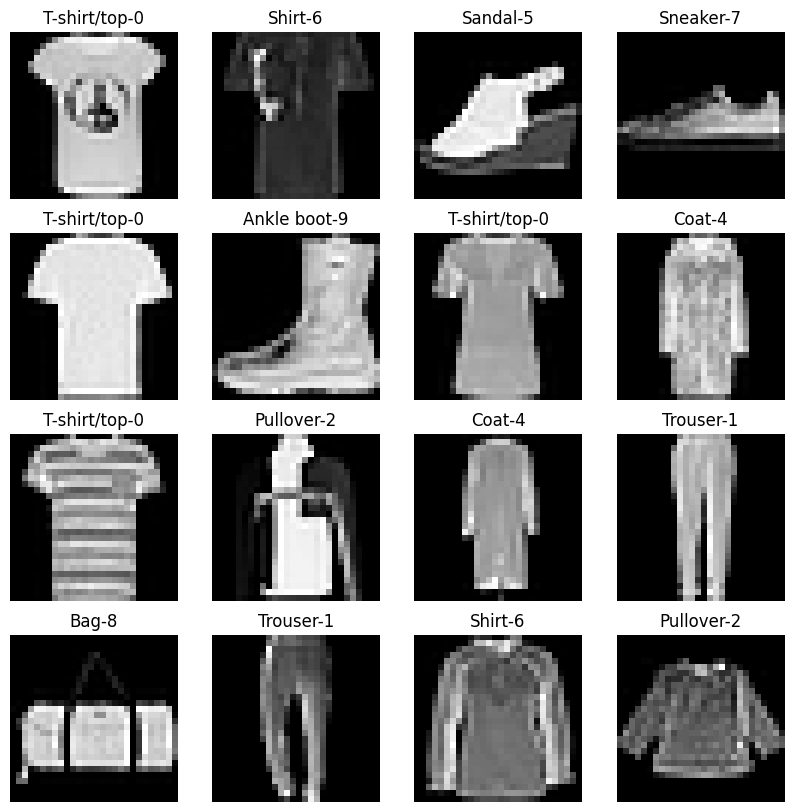

In [7]:
# Lets see the images of random training data with thier labels

plt.figure(figsize=(10, 10))
for i in range(16):
    random_int = torch.randint(0, len(train_data), size=(1, )).item()
    image, label = train_data[random_int]
    image = image.permute([1, 2, 0])  # because plt.imshow expects tensors to be (height, width, color_channels)
    plt.subplot(4, 4, i+1)
    plt.imshow(image, cmap="gray")
    plt.title(f"{classes[label]}-{label}")
    plt.axis("off")

plt.show()


### 2. Prepare data
- Convert the Dataset to an iterable using a DataLoader
- In an ideal world you could do the forward pass and backward pass across all of your data at once.

- But once you start using really large datasets, unless you've got infinite computing power, it's easier to break them up into batches.

- It also gives your model more opportunities to improve.

- With mini-batches (small portions of the data), gradient descent is performed more often per epoch (once per mini-batch rather than once per epoch).

In [8]:
print("Shape of the training data : ", len(train_data))
print("Shape of the testing data : ", len(test_data))

Shape of the training data :  60000
Shape of the testing data :  10000


In [9]:
# convert the data to batches of 32 image,label pair

torch.manual_seed(42)
# Setup the batch size hyperparameter
BATCH_SIZE = 32

# Turn datasets into iterables (batches)
train_dataloader = DataLoader(train_data, # dataset to turn into iterable
    batch_size=BATCH_SIZE, # how many samples per batch?
    shuffle=True # shuffle data every epoch?
)

test_dataloader = DataLoader(test_data,
    batch_size=BATCH_SIZE,
    shuffle=False # don't necessarily have to shuffle the testing data
)

# Let's check out what we've created
print(f"Dataloaders: {train_dataloader, test_dataloader}")
print(f"Length of train dataloader: {len(train_dataloader)} batches of {BATCH_SIZE}")
print(f"Length of test dataloader: {len(test_dataloader)} batches of {BATCH_SIZE}")

Dataloaders: (<torch.utils.data.dataloader.DataLoader object at 0x7b56215157e0>, <torch.utils.data.dataloader.DataLoader object at 0x7b5621516d70>)
Length of train dataloader: 1875 batches of 32
Length of test dataloader: 313 batches of 32


In [10]:
# Check out what's inside the training dataloader
train_features_batch, train_labels_batch = next(iter(train_dataloader))
train_features_batch.shape, train_labels_batch.shape

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

Image size: torch.Size([1, 28, 28])
Label: 2, label size: torch.Size([])


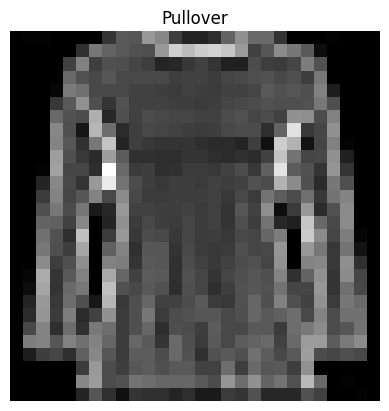

In [11]:
# Show a sample

random_idx = torch.randint(0, len(train_features_batch), size=[1]).item()
img, label = train_features_batch[random_idx], train_labels_batch[random_idx]
plt.imshow(img.squeeze(), cmap="gray")
plt.title(classes[label])
plt.axis("Off");
print(f"Image size: {img.shape}")
print(f"Label: {label}, label size: {label.shape}")

### 3. Model 0: Build a baseline model

In [12]:
# Create a flatten layer
flatten_model = nn.Flatten() # all nn modules function as a model (can do a forward pass)

# Get a single sample
x = train_features_batch[0]

# Flatten the sample
output = flatten_model(x) # perform forward pass

# Print out what happened
print(f"Shape before flattening: {x.shape} -> [color_channels, height, width]")
print(f"Shape after flattening: {output.shape} -> [color_channels, height*width]")

# Try uncommenting below and see what happens
#print(x)
#print(output)

Shape before flattening: torch.Size([1, 28, 28]) -> [color_channels, height, width]
Shape after flattening: torch.Size([1, 784]) -> [color_channels, height*width]


In [13]:
# Model 0 :simple linear model
from torch import nn
class FashionMNISTModelV0(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(), # neural networks like their inputs in vector form
            nn.Linear(in_features=input_shape, out_features=hidden_units), # in_features = number of features in a data sample (784 pixels)
            nn.Linear(in_features=hidden_units, out_features=output_shape)
        )

    def forward(self, x):
        return self.layer_stack(x)

In [14]:
torch.manual_seed(42)

# Need to setup model with input parameters
model_0 = FashionMNISTModelV0(input_shape=784, # one for every pixel (28x28)
    hidden_units=10, # how many units in the hidden layer
    output_shape=len(classes) # one for every class
)
model_0.to("cpu") # keep model on CPU to begin with

FashionMNISTModelV0(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=10, bias=True)
    (2): Linear(in_features=10, out_features=10, bias=True)
  )
)

In [15]:
# Create loss, optimizer and accuracy function

def accuracy_fn(y_true, y_pred):
    corrects = torch.eq(y_true, y_pred).sum().item()
    return (corrects / len(y_true)) * 100

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(), lr=0.01)

In [16]:
# Create the training and testing loops with dataloader
from tqdm.auto import tqdm

torch.manual_seed(42)

epochs = 5

for i in tqdm(range(epochs)):
    print(f"Epoch : {i} \n-----------")

    # Training loop of batches
    train_loss = 0
    train_acc = 0

    for batch, (X, y) in enumerate(train_dataloader):
        model_0.train()
        y_preds = model_0(X)
        loss = loss_fn(y_preds, y)
        train_loss += loss
        train_acc += accuracy_fn(y, y_preds.argmax(dim=1))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 400 == 0:
            print(f"Looked at {batch * len(X)} / {len(train_dataloader.dataset)} samples.")

    # Avg. training loss per epoch
    train_loss /= len(train_dataloader)

    # Avg. training accuracy per epoch
    train_acc /= len(train_dataloader)

    # Testing loop of batches
    test_loss = 0
    test_acc = 0
    model_0.eval()
    with torch.inference_mode():
        for batch, (X, y) in enumerate(test_dataloader):
            test_pred = model_0(X)
            test_loss += loss_fn(test_pred, y)
            test_acc += accuracy_fn(y, test_pred.argmax(dim=1))

        # Avg. testing loss
        test_loss /= len(test_dataloader)

        # Avg. test accuracy
        test_acc /= len(test_dataloader)


    print(f"\nTrain loss: {train_loss:.5f}, Train acc: {train_acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%\n")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch : 0 
-----------
Looked at 0 / 60000 samples.
Looked at 12800 / 60000 samples.
Looked at 25600 / 60000 samples.
Looked at 38400 / 60000 samples.
Looked at 51200 / 60000 samples.

Train loss: 0.56452, Train acc: 80.44% | Test loss: 0.50877, Test acc: 82.24%

Epoch : 1 
-----------
Looked at 0 / 60000 samples.
Looked at 12800 / 60000 samples.
Looked at 25600 / 60000 samples.
Looked at 38400 / 60000 samples.
Looked at 51200 / 60000 samples.

Train loss: 0.50134, Train acc: 82.77% | Test loss: 0.48985, Test acc: 83.05%

Epoch : 2 
-----------
Looked at 0 / 60000 samples.
Looked at 12800 / 60000 samples.
Looked at 25600 / 60000 samples.
Looked at 38400 / 60000 samples.
Looked at 51200 / 60000 samples.

Train loss: 0.48092, Train acc: 83.44% | Test loss: 0.57256, Test acc: 80.47%

Epoch : 3 
-----------
Looked at 0 / 60000 samples.
Looked at 12800 / 60000 samples.
Looked at 25600 / 60000 samples.
Looked at 38400 / 60000 samples.
Looked at 51200 / 60000 samples.

Train loss: 0.47964, Tr

### 4. Make predictions and get Model 0 results

In [17]:
torch.manual_seed(42)
def eval_model(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               accuracy_fn):
    """Returns a dictionary containing the results of model predicting on data_loader.

    Args:
        model (torch.nn.Module): A PyTorch model capable of making predictions on data_loader.
        data_loader (torch.utils.data.DataLoader): The target dataset to predict on.
        loss_fn (torch.nn.Module): The loss function of model.
        accuracy_fn: An accuracy function to compare the models predictions to the truth labels.

    Returns:
        (dict): Results of model making predictions on data_loader.
    """
    loss, acc = 0, 0
    model.eval()
    with torch.inference_mode():
        for X, y in tqdm(data_loader):
            # Make predictions with the model
            y_pred = model(X)

            # Accumulate the loss and accuracy values per batch
            loss += loss_fn(y_pred, y)
            acc += accuracy_fn(y_true=y,
                                y_pred=y_pred.argmax(dim=1)) # For accuracy, need the prediction labels (logits -> pred_prob -> pred_labels)

        # Scale loss and acc to find the average loss/acc per batch
        loss /= len(data_loader)
        acc /= len(data_loader)

    return {"model_name": model.__class__.__name__, # only works when model was created with a class
            "model_loss": loss.item(),
            "model_acc": acc}

# Calculate model 0 results on test dataset
model_0_results = eval_model(model=model_0, data_loader=test_dataloader,
    loss_fn=loss_fn, accuracy_fn=accuracy_fn
)
model_0_results

  0%|          | 0/313 [00:00<?, ?it/s]

{'model_name': 'FashionMNISTModelV0',
 'model_loss': 0.494508296251297,
 'model_acc': 83.16693290734824}

### 5. Setup device agnostic-code

In [18]:
# Setup device agnostic code
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

### 6. Model 1: Building a better model with non-linearity

In [19]:
# Create a model with non-linear and linear layers
class FashionMNISTModelV1(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(), # flatten inputs into single vector
            nn.Linear(in_features=input_shape, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=output_shape),
            nn.ReLU()
        )

    def forward(self, x: torch.Tensor):
        return self.layer_stack(x)

In [20]:
torch.manual_seed(42)
model_1 = FashionMNISTModelV1(input_shape=784, # number of input features
    hidden_units=10,
    output_shape=len(classes) # number of output classes desired
).to(device) # send model to GPU if it's available
next(model_1.parameters()).device # check model device

device(type='cuda', index=0)

In [21]:
# Create loss, optimizer and accuracy function

def accuracy_fn(y_true, y_pred):
    corrects = torch.eq(y_true, y_pred).sum().item()
    return (corrects / len(y_true)) * 100

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_1.parameters(), lr=0.01)

In [22]:
# Functions to make the training and testing loops easy to use
def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_fn,
               device: torch.device = device):
    train_loss, train_acc = 0, 0
    model.to(device)
    for batch, (X, y) in enumerate(data_loader):
        # Send data to GPU
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss
        train_acc += accuracy_fn(y_true=y,
                                 y_pred=y_pred.argmax(dim=1)) # Go from logits -> pred labels

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

    # Calculate loss and accuracy per epoch and print out what's happening
    train_loss /= len(data_loader)
    train_acc /= len(data_loader)
    print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.2f}%")

def test_step(data_loader: torch.utils.data.DataLoader,
              model: torch.nn.Module,
              loss_fn: torch.nn.Module,
              accuracy_fn,
              device: torch.device = device):
    test_loss, test_acc = 0, 0
    model.to(device)
    model.eval() # put model in eval mode
    # Turn on inference context manager
    with torch.inference_mode():
        for X, y in data_loader:
            # Send data to GPU
            X, y = X.to(device), y.to(device)

            # 1. Forward pass
            test_pred = model(X)

            # 2. Calculate loss and accuracy
            test_loss += loss_fn(test_pred, y)
            test_acc += accuracy_fn(y_true=y,
                y_pred=test_pred.argmax(dim=1) # Go from logits -> pred labels
            )

        # Adjust metrics and print out
        test_loss /= len(data_loader)
        test_acc /= len(data_loader)
        print(f"Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.2f}%\n")

In [23]:
# Train and test the model_1

torch.manual_seed(42)
epochs = 5
for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n---------")
    train_step(data_loader=train_dataloader,
        model=model_1,
        loss_fn=loss_fn,
        optimizer=optimizer,
        accuracy_fn=accuracy_fn
    )
    test_step(data_loader=test_dataloader,
        model=model_1,
        loss_fn=loss_fn,
        accuracy_fn=accuracy_fn
    )

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 0
---------
Train loss: 0.77872 | Train accuracy: 72.19%
Test loss: 0.72671 | Test accuracy: 74.80%

Epoch: 1
---------
Train loss: 0.69171 | Train accuracy: 74.85%
Test loss: 0.74682 | Test accuracy: 72.90%

Epoch: 2
---------
Train loss: 0.66968 | Train accuracy: 75.67%
Test loss: 0.70321 | Test accuracy: 74.17%

Epoch: 3
---------
Train loss: 0.65964 | Train accuracy: 75.94%
Test loss: 0.71329 | Test accuracy: 75.00%

Epoch: 4
---------
Train loss: 0.65331 | Train accuracy: 76.29%
Test loss: 0.67027 | Test accuracy: 75.82%



In [24]:
# Move values to device
torch.manual_seed(42)
def eval_model(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               accuracy_fn,
               device: torch.device = device):
    """Evaluates a given model on a given dataset.

    Args:
        model (torch.nn.Module): A PyTorch model capable of making predictions on data_loader.
        data_loader (torch.utils.data.DataLoader): The target dataset to predict on.
        loss_fn (torch.nn.Module): The loss function of model.
        accuracy_fn: An accuracy function to compare the models predictions to the truth labels.
        device (str, optional): Target device to compute on. Defaults to device.

    Returns:
        (dict): Results of model making predictions on data_loader.
    """
    loss, acc = 0, 0
    model.eval()
    with torch.inference_mode():
        for X, y in tqdm(data_loader):
            # Send data to the target device
            X, y = X.to(device), y.to(device)
            y_pred = model(X)
            loss += loss_fn(y_pred, y)
            acc += accuracy_fn(y_true=y, y_pred=y_pred.argmax(dim=1))

        # Scale loss and acc
        loss /= len(data_loader)
        acc /= len(data_loader)
    return {"model_name": model.__class__.__name__, # only works when model was created with a class
            "model_loss": loss.item(),
            "model_acc": acc}

# Calculate model 1 results with device-agnostic code
model_1_results = eval_model(model=model_1, data_loader=test_dataloader,
    loss_fn=loss_fn, accuracy_fn=accuracy_fn,
    device=device
)
model_1_results

  0%|          | 0/313 [00:00<?, ?it/s]

{'model_name': 'FashionMNISTModelV1',
 'model_loss': 0.6702747941017151,
 'model_acc': 75.81869009584665}

### 7. Model 2: Building a Convolutional Neural Network (CNN)

In [25]:
class FashionMNISTModelV2(nn.Module):
    def __init__(self, input_shape, hidden_units, output_shape):
        super().__init__()
        # There will be 3 blocks of convnet

        # Block 1
        self.block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2) # default stride value is same as kernel_size
        )

        # Block 2
        self.block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, 3, 1, 1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, 3, 1, 1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        # Block 3
        self.classifier = nn.Sequential(
            nn.Flatten(),
            # Where did this in_features shape come from?
            # It's because each layer of our network compresses and changes the shape of our input data.
            nn.Linear(in_features=hidden_units*7*7, # This is calculated using the dimensions
                      out_features=output_shape)
        )

    def forward(self, x):
        x = self.block_1(x)
        # print(x.shape)
        x = self.block_2(x)
        # print(x.shape)
        x = self.classifier(x)
        # print(x.shape)
        return x

In [26]:
torch.manual_seed(42)
model_2 = FashionMNISTModelV2(input_shape=1,
    hidden_units=10,
    output_shape=len(classes)).to(device)
model_2

FashionMNISTModelV2(
  (block_1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)

In [27]:
# Loss and optimizer

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_2.parameters(), lr=0.01)


In [28]:
# Training and Testing loop
torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs = 5
for i in tqdm(range(epochs)):
    print(f"Epoch {i} \n-----------")
    train_step(model=model_2,
               data_loader=train_dataloader,
               loss_fn=loss_fn,
               optimizer=optimizer,
               accuracy_fn=accuracy_fn,
               device=device)

    test_step(data_loader=test_dataloader,
        model=model_2,
        loss_fn=loss_fn,
        accuracy_fn=accuracy_fn,
        device=device)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 0 
-----------
Train loss: 0.49102 | Train accuracy: 82.07%
Test loss: 0.40546 | Test accuracy: 85.11%

Epoch 1 
-----------
Train loss: 0.38453 | Train accuracy: 85.94%
Test loss: 0.39809 | Test accuracy: 85.06%

Epoch 2 
-----------
Train loss: 0.36507 | Train accuracy: 86.76%
Test loss: 0.38901 | Test accuracy: 85.96%

Epoch 3 
-----------
Train loss: 0.35039 | Train accuracy: 87.36%
Test loss: 0.36213 | Test accuracy: 86.87%

Epoch 4 
-----------
Train loss: 0.34732 | Train accuracy: 87.44%
Test loss: 0.35696 | Test accuracy: 86.92%



In [29]:
# Lets test the model
model_2_results = eval_model(
    model=model_2,
    data_loader=test_dataloader,
    loss_fn = loss_fn,
    accuracy_fn=accuracy_fn,
    device=device
)
model_2_results

  0%|          | 0/313 [00:00<?, ?it/s]

{'model_name': 'FashionMNISTModelV2',
 'model_loss': 0.3569561243057251,
 'model_acc': 86.92092651757189}

### 8.Comparing our models

In [30]:
import pandas as pd
models_data = pd.DataFrame([model_0_results,
                            model_1_results,
                            model_2_results])
models_data

,model_name,model_loss,model_acc
0,FashionMNISTModelV0,0.494508,83.166933
1,FashionMNISTModelV1,0.670275,75.818690
2,FashionMNISTModelV2,0.356956,86.920927


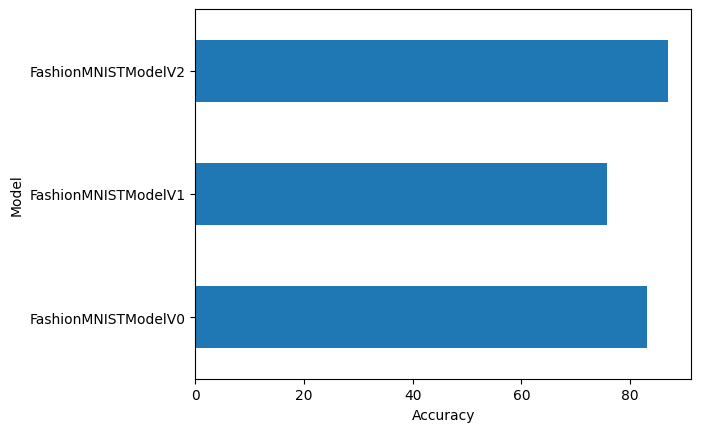

In [31]:
# Visualize the results
models_data.set_index("model_name")["model_acc"].plot(kind="barh")
plt.xlabel("Accuracy")
plt.ylabel("Model")
plt.show()

###9. Evaluating our best model

In [32]:
# Lets see what the predictions look like
def make_predictions(model, data, device="cuda"):
    pred_probs = []
    model.to(device)
    model.eval()
    with torch.inference_mode():
        for sample in data:
            sample = torch.unsqueeze(sample, dim=0).to(device)
            pred_logit = model(sample)
            pred_prob = torch.softmax(pred_logit.squeeze(), dim=0)
            pred_probs.append(pred_prob.cpu())
    return torch.stack(pred_probs) # turning list into a tensor

In [33]:
import random
random.seed(42)
test_samples = []
test_labels = []
for sample, label in random.sample(list(test_data), k=9):
    test_samples.append(sample)
    test_labels.append(label)

# View the first test sample shape and label
print(f"Test sample image shape: {test_samples[0].shape}\nTest sample label: {test_labels[0]} ({classes[test_labels[0]]})")

Test sample image shape: torch.Size([1, 28, 28])
Test sample label: 5 (Sandal)


In [34]:
# Make predictions on test samples with model 2
pred_probs= make_predictions(model=model_2,
                             data=test_samples)

# View first prediction probabilities list
pred_probs[0]

tensor([3.6391e-08, 1.6630e-10, 1.0270e-08, 4.5252e-11, 5.5570e-10, 9.9712e-01,
        1.2820e-07, 1.5205e-06, 2.1297e-05, 2.8574e-03])

In [35]:
# Turn the prediction probabilities into prediction labels by taking the argmax()
pred_classes = pred_probs.argmax(dim=1)
pred_classes

tensor([5, 1, 7, 2, 3, 0, 4, 7, 1])

In [36]:
# Are our predictions in the same form as our test labels?
test_labels, pred_classes

([5, 1, 7, 4, 3, 0, 4, 7, 1], tensor([5, 1, 7, 2, 3, 0, 4, 7, 1]))

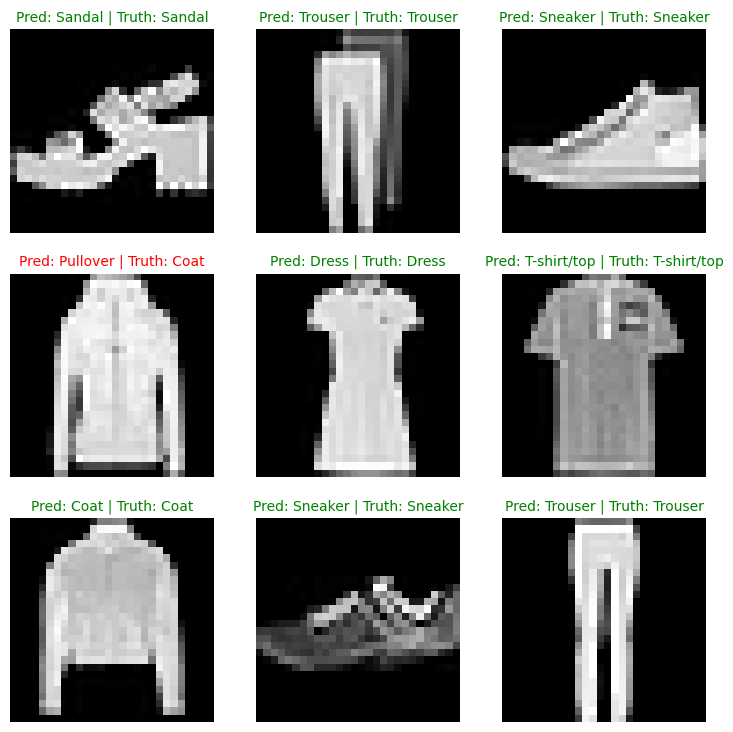

In [37]:
# Plot predictions
plt.figure(figsize=(9, 9))
nrows = 3
ncols = 3
for i, sample in enumerate(test_samples):
  # Create a subplot
  plt.subplot(nrows, ncols, i+1)

  # Plot the target image
  plt.imshow(sample.squeeze(), cmap="gray")

  # Find the prediction label (in text form, e.g. "Sandal")
  pred_label = classes[pred_classes[i]]

  # Get the truth label (in text form, e.g. "T-shirt")
  truth_label = classes[test_labels[i]]

  # Create the title text of the plot
  title_text = f"Pred: {pred_label} | Truth: {truth_label}"

  # Check for equality and change title colour accordingly
  if pred_label == truth_label:
      plt.title(title_text, fontsize=10, c="g") # green text if correct
  else:
      plt.title(title_text, fontsize=10, c="r") # red text if wrong
  plt.axis(False);


### 10. Making a confusion matrix for further prediction evaluation

- To make a confusion matrix, we'll go through three steps:

1. Make predictions with our trained model, model_2 (a confusion matrix compares predictions to true labels).
2. Make a confusion matrix using torchmetrics.ConfusionMatrix.
3. Plot the confusion matrix using mlxtend.plotting.plot_confusion_matrix()

In [38]:
from tqdm.auto import tqdm

y_preds = []
model_2.eval()
with torch.inference_mode():
  for X, y in tqdm(test_dataloader, desc="Making predictions"):
    X, y = X.to(device), y.to(device)
    y_logit = model_2(X)
    y_pred = torch.softmax(y_logit, dim=1).argmax(dim=1) # note: perform softmax on the "logits" dimension, not "batch" dimension (in this case we have a batch size of 32, so can perform on dim=1)
    y_preds.append(y_pred.cpu())
y_pred_tensor = torch.cat(y_preds)

Making predictions:   0%|          | 0/313 [00:00<?, ?it/s]

In [39]:
# See if torchmetrics exists, if not, install it
try:
    import torchmetrics, mlxtend
    print(f"mlxtend version: {mlxtend.__version__}")
    assert int(mlxtend.__version__.split(".")[1]) >= 19, "mlxtend verison should be 0.19.0 or higher"
except:
    !pip install -q torchmetrics -U mlxtend # <- Note: If you're using Google Colab, this may require restarting the runtime
    import torchmetrics, mlxtend
    print(f"mlxtend version: {mlxtend.__version__}")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 926.4/926.4 kB 13.6 MB/s eta 0:00:00
mlxtend version: 0.23.3


In [40]:
# Import mlxtend upgraded version
import mlxtend
print(mlxtend.__version__)
assert int(mlxtend.__version__.split(".")[1]) >= 19 # should be version 0.19.0 or higher

0.23.3


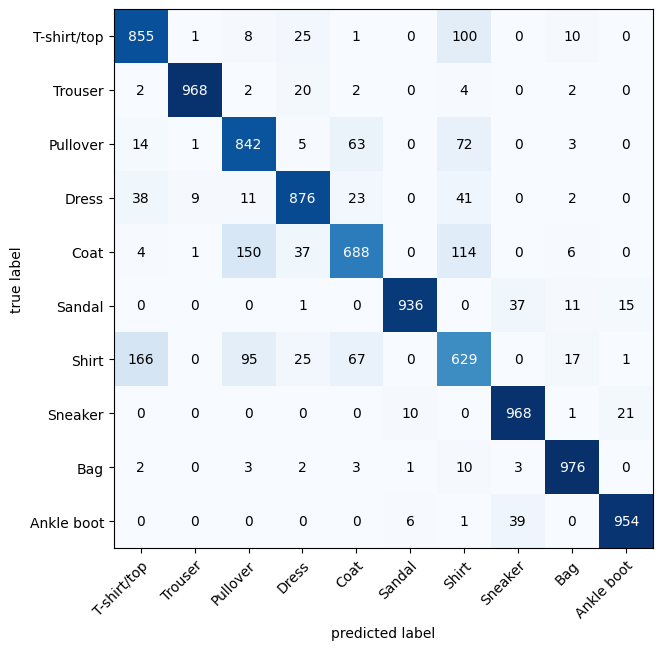

In [42]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

# 2. Setup confusion matrix instance and compare predictions to targets
confmat = ConfusionMatrix(num_classes=len(classes), task='multiclass')
confmat_tensor = confmat(preds=y_pred_tensor,
                         target=test_data.targets)

# 3. Plot the confusion matrix
fig, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(), # matplotlib likes working with NumPy
    class_names=classes, # turn the row and column labels into class names
    figsize=(10, 7)
)

### 11. Save and load best performing model

In [43]:
from pathlib import Path

MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

MODEL_NAME = "fashion_mnist_cnn_model.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

print(f"Saving model to path : {MODEL_SAVE_PATH}")
torch.save(obj=model_2.state_dict(),f=MODEL_SAVE_PATH)

Saving model to path : models/fashion_mnist_cnn_model.pth


In [44]:
# Create a new instance of FashionMNISTModelV2 (the same class as our saved state_dict())
# Note: loading model will error if the shapes here aren't the same as the saved version
loaded_model_2 = FashionMNISTModelV2(input_shape=1,
                                    hidden_units=10, # try changing this to 128 and seeing what happens
                                    output_shape=10)

# Load in the saved state_dict()
loaded_model_2.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

# Send model to GPU
loaded_model_2 = loaded_model_2.to(device)

<ipython-input-44-01e1a5266d0e>:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model_2.load_state_dict(torch.load(f=MODEL_SAVE_PATH))


In [45]:
# Evaluate loaded model
torch.manual_seed(42)

loaded_model_2_results = eval_model(
    model=loaded_model_2,
    data_loader=test_dataloader,
    loss_fn=loss_fn,
    accuracy_fn=accuracy_fn
)

loaded_model_2_results

  0%|          | 0/313 [00:00<?, ?it/s]

{'model_name': 'FashionMNISTModelV2',
 'model_loss': 0.3569561243057251,
 'model_acc': 86.92092651757189}

In [46]:
model_2_results

{'model_name': 'FashionMNISTModelV2',
 'model_loss': 0.3569561243057251,
 'model_acc': 86.92092651757189}

### Conclusion :
- CNN Models are very well suited for unstructured data (image, audio, video, etc.)